# **Introduction**

This notebook is for testing hyperparameter optimization using `Optuna`, which is a hyperparameter optimization framework used to automate hyperparameter searching. The idea is to take the DQN implementation developed for `Cartpole`, both the base and swingup versions, and perform a hyperparameter search to optimize their performance using `Optuna`. The hyperparameters that will be optimized are:

* The learning rate: α
* The discount rate: γ
* The epsilon decay rate: $ε_{d}$
* The final epsilon value: $ε_{f}$
* The replay buffer size: $n_{buff}$
* The batch size: $n_{batch}$
* The target update frequency: $f_{target}$
* The training frequency: $f_{train}$
* The warmup length: $n_{warm}$
* The number of neurons per layer: $n_{neurons}$
* The number of layers: $n_{layers}$

With the goal being to maximize the average return per episode while training the model over a set number of episodes, for a set number of trials.

# **Import Packages**

This section imports the necessary packages.

In [ ]:
# import these packages:
import gymnasium as gym
from wrappers.swingup_wrapper import SwingUpWrapper
import numpy as np
import optuna
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from collections import deque

# **Environment Setup** 

This section sets up the environment and defines all relevant functions needed for this implementation.

##### Function for making Keras models:

In [181]:
# function for making a keras model:
def make_model(layers, neurons, rate, norm, drop, input_shape, output_shape, loss_function):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(output_shape, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    return model 

##### DQN class:

In [182]:
# DQN agent class:
class DQN_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self, 
        env: gym.Env, 
        gamma: float, 
        lr: float,
        epsilon: float,
        epsilon_min: float,
        epsilon_decay: float,
        batch_size: int,
        buffer_size: int,
        target_update_freq: int, 
        train_freq: int,
        layers = int,
        neurons = int, 
        seed = int):
        """ 
        this is the constructor for the agent. this agent uses a DQN to learn an optimal policy, through the use of approximator neural network 
        to approximate action-value Q, and a target network to generate a Q-target used in the updating of Q(s,a). this is done to prevent updates
        to the network weights from changing the target, meaning that we aren't bootstrapping towards a changing target. this helps to stabilize the learning.

        env:                    a gymnasium environment
        gamma:                  a float value indicating the discount factor γ
        lr:                     a float value indicating the learning rate α
        epsilon:                a float value indicating the action-selection probability ε
        epsilon_min:            a float value indicating the minimum ε value
        epsilon_decay:          a float value indicating the decay rate of ε
        batch_size:             an int representing the batch size sampled from the experience
        buffer_size:            an int representing the size of the memory buffer
        target_update_freq:     an int representing how frequently the target network weights should be updated
        train_freq:             an int representing how frequently training should occur
        layers:                 an int representing the number of layers in each network
        neurons:                an int representing the number of neurons in each network
        seed:                   an int representing the random seed of the environment, for reproducability

        nS:         an int representing the number of states observed, each of which is continuous
        nA:         an int representing the number of discrete actions that can be taken

        q_network:                  a Keras sequential neural network representing the actual function approximator
        target_network:             a Keras sequential neural network representing responsible for generating Q-targets
        experience:                 an empty deque used to hold the experience history of the agent, limited to buffer_size


        """
        # object parameters:
        self.env = env
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # get the environment dimensions:
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n

        # experience history and mini-batch size:
        self.replay_buffer = deque(maxlen = buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.step_counter = 0

        # initialize networks:
        self.q_network = make_model(layers = layers, neurons = neurons, rate = lr,
                                                norm = True, drop = True,
                                                input_shape = self.nS, output_shape = self.nA,
                                                loss_function = 'mse')
        self.target_network = keras.models.clone_model(self.q_network)
        self.target_network.set_weights(self.q_network.get_weights())

        # set target update and training frequencies:
        self.target_update_freq = target_update_freq
        self.train_freq = train_freq

        # set the seed:
        self.seed = seed

    ####################### TRAINING #######################
    # define a decorated function to infer Q's from batched states (this is the implicit policy):
    @tf.function
    def get_qs(self, obs_batch):
        return self.q_network(obs_batch)
    
    # define a decorated function to perform the DQN training step for updating Q network weights:
    @tf.function
    def training_step(self, states, actions, rewards, next_states, dones):
        # track auto differentiation:
        with tf.GradientTape() as tape:
            # 1) do a forward pass to get Q values:
            # this is all the Q values from every state:
            q_all = self.q_network(states)

            # find relevant index of actions that will be selected:
            index = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis = 1)

            # gather up the Q values that correspond to actions actually taken:
            q_selected = tf.gather_nd(q_all, index)

            # 2) compute TD-targets:
            # TD-target is computed with S', A', w-:
            q_next = self.target_network(next_states)

            # get the Q value corresponding to the max over the actions:
            max_q_next = tf.reduce_max(q_next, axis = 1)

            # compute actual TD-targets:
            targets = tf.stop_gradient(rewards + (1 - dones) * self.gamma * max_q_next)

            # 3) MSE loss between the Qs that correspond to taken actions and the TD-target:
            loss = tf.reduce_mean(tf.square(q_selected - targets))
        
        # 4) backpropagate and update the weights:
        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

    # training function:
    def training(self, training_length, on_episode_end = None):

        reward_history = np.zeros(training_length)

        # for every episode:
        # for episode in tqdm(range(training_length), colour = "#33FF00", ncols = 100, desc = "training progress"):
        for episode in range(training_length):
            # reset environment:
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False

            # while false:
            while not done:
                # ε-greedy policy:
                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    obs_batch = tf.expand_dims(tf.convert_to_tensor(obs, dtype = tf.float32), 0)
                    qs = self.get_qs(obs_batch)
                    action = tf.argmax(qs[0]).numpy()

                # interact with the environment:
                next_obs, reward, term, trunc, _ = self.env.step(action)
                done = term or trunc
                self.replay_buffer.append((obs, action, reward, next_obs, done))
                obs = next_obs
                episode_reward += reward
                self.step_counter += 1

                # sample a batch of experience:
                if len(self.replay_buffer) >= self.batch_size and self.step_counter % self.train_freq == 0:
                    # get a batch:
                    batch = random.sample(self.replay_buffer, self.batch_size)

                    # unpack the batch:
                    states, actions, rewards, next_states, dones = zip(*batch)

                    # convert to tensors:
                    states = tf.convert_to_tensor(states, dtype = tf.float32)
                    actions = tf.convert_to_tensor(actions, dtype = tf.int32)
                    rewards = tf.convert_to_tensor(rewards, dtype = tf.float32)
                    next_states = tf.convert_to_tensor(next_states, dtype = tf.float32)
                    dones = tf.convert_to_tensor(dones, dtype = tf.float32)

                    # single graph call:
                    self.training_step(states, actions, rewards, next_states, dones)

                    # update target network periodically:
                    if self.step_counter % self.target_update_freq == 0:
                        self.target_network.set_weights(self.q_network.get_weights())

            # decay epsilon:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # advance reward history:
            reward_history[episode] = episode_reward

            # callback for pruning:
            if on_episode_end is not None:
                on_episode_end(episode, episode_reward)
        
        return reward_history

##### Objective function for Optuna:

In [183]:
# moving average function:
def moving_average(interval, window_size):
        window = np.ones(int(window_size)) / float(window_size)
        return np.convolve(interval, window, 'same')

# define an objective function that takes a trial object:
def objective(trial):
    # 0) initialization:
    # clear the backend:
    tf.keras.backend.clear_session()

    # define parameters for moving average used in pruning:
    window_size = 20
    recent_rewards = deque(maxlen = window_size)
    
    # define a callback that can be used every episode:
    def prune_callback(episode, episode_reward):
        # collect episode rewards into the deque:
        recent_rewards.append(episode_reward)

        # compute average reward:
        avg_reward = sum(recent_rewards) / len(recent_rewards)

        # prune report:
        trial.report(avg_reward, step = episode)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # 1) create an environment:
    env = gym.make("CartPole-v1")

    # seeding:
    np.random.seed(18)
    random.seed(18)
    tf.random.set_seed(18)
    _, _ = env.reset(seed = 18)

    # 2) create an agent:
    # instantiate the agent:
    dqn_agent = DQN_Agent(env                   =       env,
                          gamma                 =       trial.suggest_categorical('gamma', [0.95, 0.99, 0.995, 0.999]),
                          lr                    =       trial.suggest_categorical('lr', [1e-5, 1e-4, 1e-3, 1e-2]),
                          epsilon               =       1.0,
                          epsilon_min           =       trial.suggest_categorical('epsilon_min', [0.01, 0.05, 0.1]),
                          epsilon_decay         =       trial.suggest_categorical('epsilon_decay', [0.99, 0.9925, 0.995]),
                          batch_size            =       trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
                          buffer_size           =       trial.suggest_int('buffer_size', low = 1000, high = 10000, step = 1000),
                          target_update_freq    =       trial.suggest_categorical('target_update_freq', [10, 100, 1000]),
                          train_freq            =       trial.suggest_categorical('train_freq', [1, 2, 4, 8]), 
                          layers                =       trial.suggest_categorical('layers', [2, 3]), 
                          neurons               =       trial.suggest_categorical('neurons', [32, 64, 128])
                          )
    

    # 3) populate the replay buffer:
    obs, _ = dqn_agent.env.reset()
    for _ in range(trial.suggest_int('warmup_length', low = 1000, high = 10000, step = 1000)):
        # sample random action:
        action = dqn_agent.env.action_space.sample()

        # act on environment:
        next_obs, reward, term, trunc, _ = dqn_agent.env.step(action)

        # check for completion:
        done = term or trunc

        # append experience to agent's replay buffer:
        dqn_agent.replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs if not done else dqn_agent.env.reset()[0]

    # 4) train the agent:
    reward_history = dqn_agent.training(training_length = 1000,
                                        on_episode_end = prune_callback)

    # moving average:
    filtered_data = moving_average(reward_history, window_size)

    # 5) return metric:
    return float(filtered_data[-50:].mean().round(3))


# **Using the Environment**

This section performs the hyperparameter searching.

##### Query user about mode:

In [184]:
mode = input(f"Please select mode: Optimize or Analyze").lower()

if mode not in ["optimize", "analyze"]:
    raise SystemExit(f"Invalid mode selected.")

##### Create study and optimize:

In [ ]:
if mode == "optimize":
    # get run time:
    time = datetime.datetime.now()
    formatted_time = time.strftime("%Y_%m_%d_%H_%M")

    # set study name:
    study_name = f"DQN_HPO_{formatted_time}"

    # create a study object and optimize the objective function:
    study = optuna.create_study(study_name = study_name, 
                                direction = 'maximize',
                                storage = "sqlite:///optuna_results.db",
                                load_if_exists = False, 
                                pruner = optuna.pruners.MedianPruner(n_startup_trials = 5,
                                                                    n_warmup_steps = 500))
    study.optimize(objective, n_trials = 375, show_progress_bar = True)

##### Summarize results of study:

In [ ]:
if mode == "analyze":
    # manually set the study to be analyzed:
    study_name = "DQN_HPO"

    # load the study:
    study = optuna.load_study(study_name = study_name,
                              storage = "sqlite:///optuna_results.db")
    
    # summarize study:
    trials_data = []
    intermediate_values = []
    for trial in study.best_trials:
        # initialize dicts:
        trial_data = {}
        intermediate_value = {}

        # get trial information:
        trial_data["model"] = trial.number
        trial_data['value'] = trial.value
        trial_data.update(trial.params.copy())
        trials_data.append(trial_data)

        # get intermediate values:
        intermediate_value.update(trial.intermediate_values.copy())
        intermediate_values.append(intermediate_value)

    # make data frame:
    summary = pd.DataFrame(trials_data)
    

In [222]:
# show the best 10 models:
summary.head(5).sort_values(by = 'value', ascending = False)

,model,value,gamma,lr,epsilon_min,epsilon_decay,batch_size,buffer_size,target_update_freq,train_freq,layers,neurons,warmup_length
0,7,477.5,0.999,0.0001,0.01,0.9925,256,8000,100,2,2,128,8000
1,12,477.5,0.990,0.0001,0.01,0.9925,256,8000,100,2,2,128,3000
2,16,477.5,0.999,0.0001,0.01,0.9900,64,5000,100,2,2,128,7000
3,20,477.5,0.990,0.0001,0.01,0.9900,64,6000,100,2,2,128,3000
4,21,477.5,0.999,0.0001,0.01,0.9900,64,5000,100,2,2,128,7000


##### Visualize results of study:

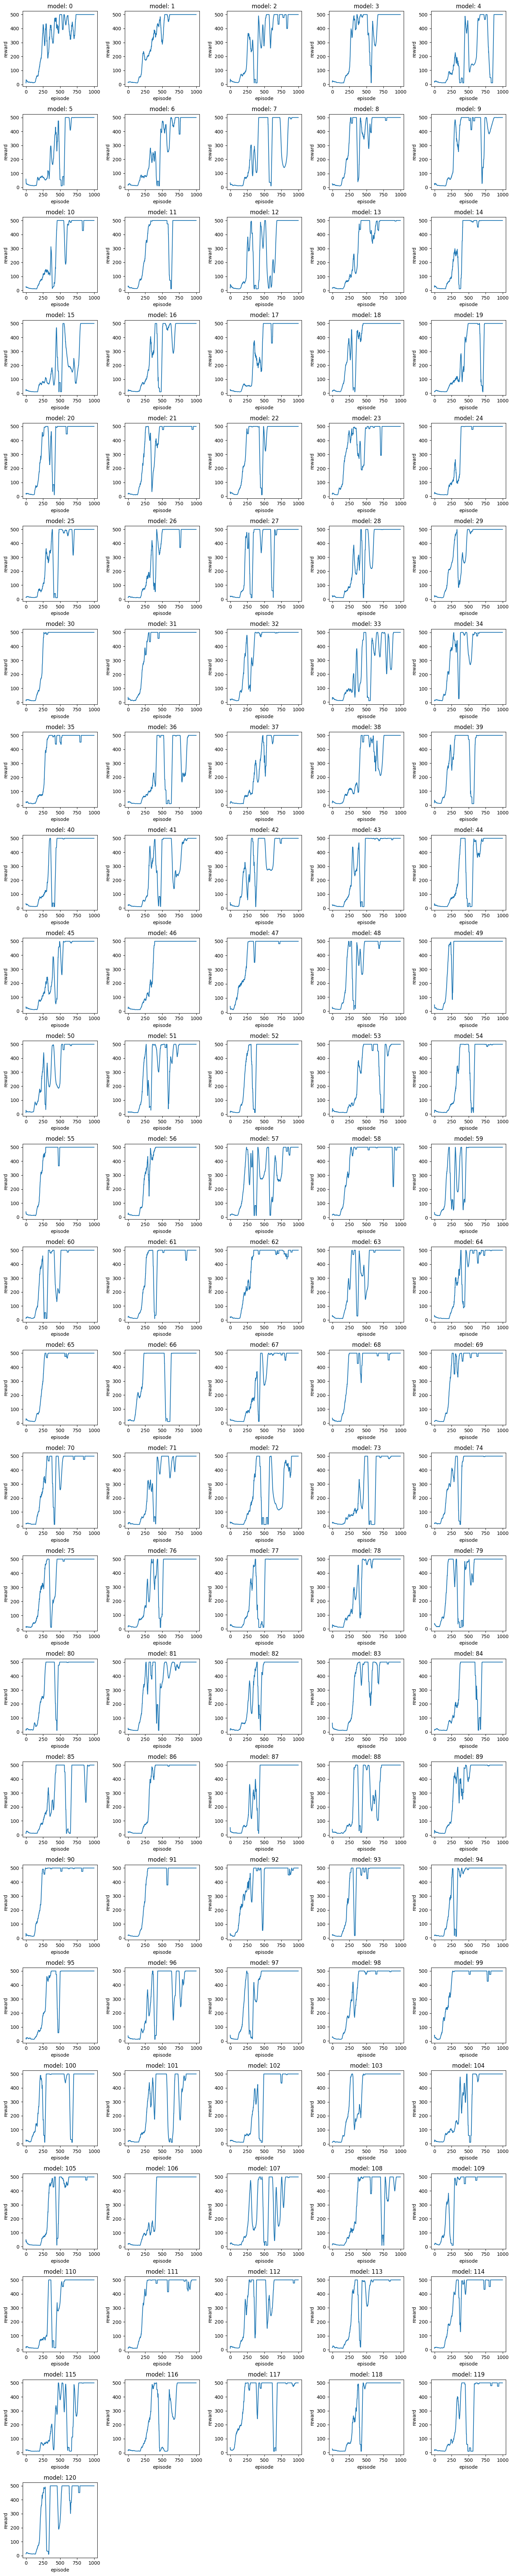

In [224]:
if mode == "analyze":
    # setup grid for subplots:
    n_plots = len(intermediate_values)
    cols = 5
    rows = (n_plots // cols) + (1 if n_plots % cols > 0 else 0) 

    # create the figure and axes:
    fig, axes = plt.subplots(rows, cols, figsize = (15, 3 * rows))
    axes = axes.flatten()

    # loop through trials and plot on each subplot:
    for i, trial in enumerate(intermediate_values):
        x = list(trial.keys())
        y = list(trial.values())

        ax = axes[i]
        ax.plot(x, y)
        ax.set_title(f"model: {i}")
        ax.set_xlabel("episode")
        ax.set_ylabel("reward")

    # hide unused subplots (if there are any):
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # adjust layout to prevent overlapping:
    plt.tight_layout()
    plt.show()

##### Get params of best model based on the plots:

In [230]:
# visually, I determined that the best looking model was model:
model_number = 30

# get its values:
summary.loc[model_number]

model                  111.0000
value                  477.5000
gamma                    0.9990
lr                       0.0001
epsilon_min              0.0100
epsilon_decay            0.9925
batch_size             256.0000
buffer_size           9000.0000
target_update_freq     100.0000
train_freq               2.0000
layers                   2.0000
neurons                128.0000
warmup_length         6000.0000
Name: 30, dtype: float64